In [1]:
!wget https://www.dropbox.com/s/tcwbjzghs1xu8vv/ratings.csv

--2020-06-15 17:35:05--  https://www.dropbox.com/s/tcwbjzghs1xu8vv/ratings.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tcwbjzghs1xu8vv/ratings.csv [following]
--2020-06-15 17:35:05--  https://www.dropbox.com/s/raw/tcwbjzghs1xu8vv/ratings.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdda066001a2bc20c530189150f.dl.dropboxusercontent.com/cd/0/inline/A5vAFqb0MUHKAeTAYpnfocPjgvdv6DLVlPrRCAxRKG_ISrPQk61ZOnG9vz821TPc0rcgmFWJldAvjnYEYDpuO7V3QzZyJ0RjXuZCErO9kMTI4pgiukAkmnMCE8emyurC5oQ/file# [following]
--2020-06-15 17:35:06--  https://ucdda066001a2bc20c530189150f.dl.dropboxusercontent.com/cd/0/inline/A5vAFqb0MUHKAeTAYpnfocPjgvdv6DLVlPrRCAxRKG_ISrPQk61ZOnG9vz821TPc0rcgmFWJldAvjnYEYDpuO7V3QzZyJ0RjXuZCErO9kMTI4pgiukAkm

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
!pip install emoji text-cleaner keras sklearn pandas numpy seaborn

In [4]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.zh.300.vec.gz

--2020-06-15 17:35:16--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.zh.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1358817100 (1.3G) [binary/octet-stream]
Saving to: ‘cc.zh.300.vec.gz’

cc.zh.300.vec.gz    100%[===================>]   1.26G  22.9MB/s    in 41s     

2020-06-15 17:35:58 (31.6 MB/s) - ‘cc.zh.300.vec.gz’ saved [1358817100/1358817100]



In [5]:
!gunzip cc.zh.300.vec.gz

gzip: cc.zh.300.vec already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [6]:
import pandas as pd
import numpy as np
import re
import emoji

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from text_cleaner import remove
from text_cleaner.processor.chinese import CHINESE, CHINESE_SYMBOLS_AND_PUNCTUATION
from text_cleaner import remove
from text_cleaner.processor.common import ASCII, SYMBOLS_AND_PUNCTUATION_EXTENSION, GENERAL_PUNCTUATION
import seaborn as sns

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
movie_reviews = pd.read_csv("ratings.csv")

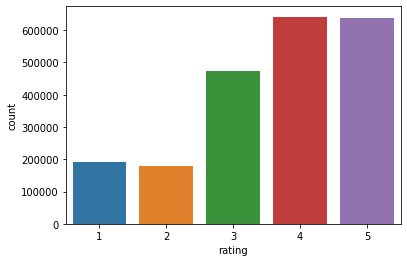

In [8]:
sns.countplot(x='rating', data=movie_reviews)

In [0]:
def escape_emoji(text):
    emoji_pattern = re.compile(
        u'(\U0001F1F2\U0001F1F4)|'       # Macau flag
        u'([\U0001F1E6-\U0001F1FF]{2})|' # flags
        u'([\U0001F600-\U0001F64F])'     # emoticons
        "+", flags=re.UNICODE)
    return emoji_pattern.sub('', text)


def escape_en_char(string):
    en_pattern = "[a-zA-Z0-9]+"
    one_str = re.sub(en_pattern, ' ', string)
    return one_str

def remove_pun(string):
    s = SYMBOLS_AND_PUNCTUATION_EXTENSION.remove(string)
    s = GENERAL_PUNCTUATION.remove(string)
    s = CHINESE_SYMBOLS_AND_PUNCTUATION.remove(string)
    return s

In [0]:
def preprocess_text(sens):
    sentence = escape_en_char(sens)
    sentence = escape_emoji(sens)
    sentence = remove_pun(sens)
    sentence = ' '.join(sentence.split())
    return sentence

In [0]:
movie_reviews['comment'] = movie_reviews['comment'].apply(preprocess_text)

In [0]:
y_real = movie_reviews['rating'].values

In [0]:
y_train_real, y_test_real = train_test_split(y_real, test_size=0.30, random_state=42)

In [0]:
y = pd.get_dummies(movie_reviews['rating']).values
y = np.array(list(map(lambda x: x , y)))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(movie_reviews['comment'], y, test_size=0.30, random_state=42)

In [0]:
tokenizer = Tokenizer(char_level = True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(X_train)

In [0]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [0]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
fasttext_file = open('cc.zh.300.vec', encoding="utf8")

for line in fasttext_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
fasttext_file.close()

In [0]:
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [0]:
from keras.layers import Conv1D,MaxPooling1D,Bidirectional

# CNN Model for Multi-Class

In [22]:
model_cnn = Sequential()

embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_cnn.add(embedding_layer)
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(5, activation='softmax'))
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [23]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          2669700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           192128    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 2,862,473
Trainable params: 192,773
Non-trainable params: 2,669,700
_________________________________________________________________


In [24]:
history_a = model_cnn.fit(X_train, y_train, batch_size=128, epochs=25, verbose=1, validation_split=0.3)


Train on 1041277 samples, validate on 446262 samples
Epoch 1/25
1041277/1041277 [==============================] - 113s 108us/step - loss: 1.1319 - acc: 0.5026 - val_loss: 1.0952 - val_acc: 0.5176
Epoch 2/25
1041277/1041277 [==============================] - 106s 102us/step - loss: 1.0605 - acc: 0.5356 - val_loss: 1.0695 - val_acc: 0.5310
Epoch 3/25
1041277/1041277 [==============================] - 107s 103us/step - loss: 1.0329 - acc: 0.5475 - val_loss: 1.0665 - val_acc: 0.5327
Epoch 4/25
1041277/1041277 [==============================] - 107s 103us/step - loss: 1.0149 - acc: 0.5555 - val_loss: 1.0680 - val_acc: 0.5317
Epoch 5/25
1041277/1041277 [==============================] - 107s 103us/step - loss: 1.0007 - acc: 0.5616 - val_loss: 1.0719 - val_acc: 0.5300
Epoch 6/25
1041277/1041277 [==============================] - 107s 103us/step - loss: 0.9895 - acc: 0.5670 - val_loss: 1.0763 - val_acc: 0.5292
Epoch 7/25
1041277/1041277 [==============================] - 107s 103us/step - lo

In [25]:
score_cnn, acc_cnn = model_cnn.evaluate(X_test, y_test,batch_size=128)

637517/637517 [==============================] - 26s 41us/step


In [26]:
print('CNN Model score is:' ,score_cnn)
print('CNN Model accuracy is:' ,acc_cnn)

CNN Model score is: 1.1406459141414327
CNN Model accuracy is: 0.5181995034217834


In [27]:
from sklearn.metrics import classification_report
Y_pred_cnn = model_cnn.predict_classes(X_test)
print(Y_pred_cnn)

[4 3 4 ... 4 2 0]


In [28]:
np.unique(Y_pred_cnn)

array([0, 1, 2, 3, 4])

In [0]:
Y_pred_cnn = list(map(lambda x: x+1 , Y_pred_cnn))

# Classification Metrics: CNN Multi-Class  FastText

In [30]:
classes = ['1','2','3','4','5']
print('  Classification Report: CNN Multi-Class Model FastText\n',classification_report(y_test_real,Y_pred_cnn,target_names = classes ),'\n')

  Classification Report: CNN Multi-Class Model FastText
               precision    recall  f1-score   support

           1       0.58      0.56      0.57     57306
           2       0.37      0.27      0.31     53867
           3       0.45      0.51      0.48    142306
           4       0.50      0.38      0.44    192429
           5       0.59      0.71      0.64    191609

    accuracy                           0.52    637517
   macro avg       0.50      0.49      0.49    637517
weighted avg       0.51      0.52      0.51    637517
 



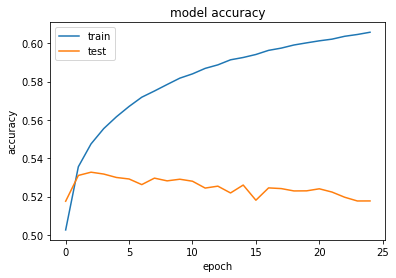

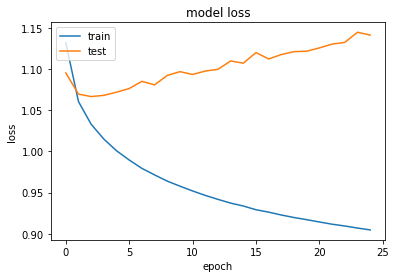

In [31]:
import matplotlib.pyplot as plt

plt.plot(history_a.history['acc'])
plt.plot(history_a.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history_a.history['loss'])
plt.plot(history_a.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# LSTM Model for Multi-Class

In [0]:
from keras.layers import CuDNNLSTM

In [0]:
model_rnn = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_rnn.add(embedding_layer)
model_rnn.add(CuDNNLSTM(100))
model_rnn.add(Dense(100,activation='relu'))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(5, activation='softmax'))
model_rnn.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

In [34]:
model_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          2669700   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               160800    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 2,841,105
Trainable params: 171,405
Non-trainable params: 2,669,700
_________________________________________________________________


In [35]:
history_b = model_rnn.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.3)

Train on 1041277 samples, validate on 446262 samples
Epoch 1/15
1041277/1041277 [==============================] - 259s 248us/step - loss: 1.4524 - acc: 0.3211 - val_loss: 1.4173 - val_acc: 0.3253
Epoch 2/15
1041277/1041277 [==============================] - 260s 250us/step - loss: 1.4294 - acc: 0.3361 - val_loss: 1.4613 - val_acc: 0.3232
Epoch 3/15
1041277/1041277 [==============================] - 260s 250us/step - loss: 1.3186 - acc: 0.4050 - val_loss: 1.2088 - val_acc: 0.4613
Epoch 4/15
1041277/1041277 [==============================] - 259s 248us/step - loss: 1.1324 - acc: 0.5044 - val_loss: 1.0813 - val_acc: 0.5267
Epoch 5/15
1041277/1041277 [==============================] - 258s 248us/step - loss: 1.0757 - acc: 0.5304 - val_loss: 1.0583 - val_acc: 0.5385
Epoch 6/15
1041277/1041277 [==============================] - 258s 248us/step - loss: 1.0534 - acc: 0.5408 - val_loss: 1.0440 - val_acc: 0.5451
Epoch 7/15
1041277/1041277 [==============================] - 257s 247us/step - los

In [36]:
score_lstm, acc_lstm = model_rnn.evaluate(X_test, y_test,batch_size=128)

637517/637517 [==============================] - 61s 95us/step


In [37]:
print('LSTM Model score is:' ,score_lstm)
print('LSTM Model accuracy is:' ,acc_lstm)

LSTM Model score is: 1.0321716592166108
LSTM Model accuracy is: 0.5518770217895508


In [38]:
from sklearn.metrics import classification_report
Y_pred_rnn = model_rnn.predict_classes(X_test)
print(Y_pred_rnn)

[4 3 4 ... 4 2 0]


In [39]:
np.unique(Y_pred_rnn)

array([0, 1, 2, 3, 4])

In [0]:
Y_pred_rnn = list(map(lambda x: x+1 , Y_pred_rnn))

# Classification Metrics: LSTM Multi-Class FastText

In [41]:
print('Training Dataset Size :',X_train.shape)
print('Testing Dataset Size :',X_test.shape)
classes = ['1','2','3','4','5']
print('Classification Report: LSTM Multi-Class Model FastText\n',classification_report(y_test_real,Y_pred_rnn,target_names = classes ),'\n')

Training Dataset Size : (1487539, 100)
Testing Dataset Size : (637517, 100)
Classification Report: LSTM Multi-Class Model FastText
               precision    recall  f1-score   support

           1       0.61      0.60      0.61     57306
           2       0.50      0.21      0.29     53867
           3       0.51      0.53      0.52    142306
           4       0.50      0.49      0.50    192429
           5       0.62      0.71      0.66    191609

    accuracy                           0.55    637517
   macro avg       0.55      0.51      0.51    637517
weighted avg       0.55      0.55      0.54    637517
 



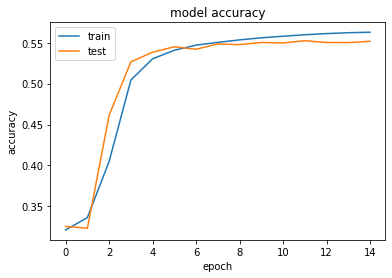

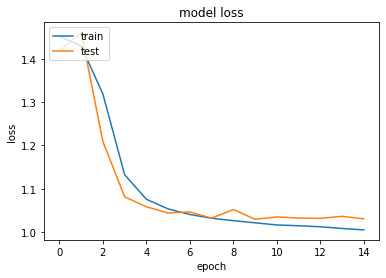

In [42]:
import matplotlib.pyplot as plt

plt.plot(history_b.history['acc'])
plt.plot(history_b.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history_b.history['loss'])
plt.plot(history_b.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# Bi-LSTM Model for Multi-Class

In [0]:
model_brnn = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_brnn.add(embedding_layer)
model_brnn.add(Bidirectional(CuDNNLSTM(100)))
model_brnn.add(Dense(100,activation='relu'))
model_brnn.add(Dropout(0.5))
model_brnn.add(Dense(5, activation='softmax'))
model_brnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [44]:
model_brnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          2669700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               321600    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 505       
Total params: 3,011,905
Trainable params: 342,205
Non-trainable params: 2,669,700
_________________________________________________________________


In [45]:
history_c = model_brnn.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.3)

Train on 1041277 samples, validate on 446262 samples
Epoch 1/10
1041277/1041277 [==============================] - 493s 474us/step - loss: 1.1884 - acc: 0.4766 - val_loss: 1.0863 - val_acc: 0.5225
Epoch 2/10
1041277/1041277 [==============================] - 491s 472us/step - loss: 1.0801 - acc: 0.5283 - val_loss: 1.0529 - val_acc: 0.5376
Epoch 3/10
1041277/1041277 [==============================] - 492s 472us/step - loss: 1.0529 - acc: 0.5413 - val_loss: 1.0481 - val_acc: 0.5404
Epoch 4/10
1041277/1041277 [==============================] - 493s 473us/step - loss: 1.0473 - acc: 0.5447 - val_loss: 1.0400 - val_acc: 0.5482
Epoch 5/10
1041277/1041277 [==============================] - 491s 472us/step - loss: 1.0447 - acc: 0.5468 - val_loss: 1.0413 - val_acc: 0.5469
Epoch 6/10
1041277/1041277 [==============================] - 491s 471us/step - loss: 1.0510 - acc: 0.5462 - val_loss: 1.0496 - val_acc: 0.5458
Epoch 7/10
1041277/1041277 [==============================] - 491s 472us/step - los

In [46]:
score_bilstm, acc_bilstm = model_brnn.evaluate(X_test, y_test,batch_size=128)

637517/637517 [==============================] - 106s 166us/step


In [47]:
print('Bi-LSTM Model score is:' ,score_bilstm)
print('Bi-LSTM Model accuracy is:' ,acc_bilstm)

Bi-LSTM Model score is: 1.057153002054698
Bi-LSTM Model accuracy is: 0.5441580414772034


In [48]:
from sklearn.metrics import classification_report
Y_pred_brnn = model_brnn.predict_classes(X_test)
print(Y_pred_brnn)

[4 3 4 ... 4 2 0]


In [49]:
np.unique(Y_pred_brnn)

array([0, 1, 2, 3, 4])

In [0]:
Y_pred_brnn = list(map(lambda x: x+1 , Y_pred_brnn))

# Classification Metrics: Bi-LSTM Multi-Class FastText

In [51]:
print('Training Dataset Size :',X_train.shape)
print('Testing Dataset Size :',X_test.shape)
classes = ['1','2','3','4','5']
print('Classification Report: Bi-LSTM Multi-Class Model FastText\n',classification_report(y_test_real,Y_pred_brnn,target_names = classes ),'\n')

Training Dataset Size : (1487539, 100)
Testing Dataset Size : (637517, 100)
Classification Report: Bi-LSTM Multi-Class Model FastText
               precision    recall  f1-score   support

           1       0.61      0.59      0.60     57306
           2       0.51      0.16      0.25     53867
           3       0.50      0.47      0.48    142306
           4       0.48      0.54      0.51    192429
           5       0.62      0.69      0.66    191609

    accuracy                           0.54    637517
   macro avg       0.54      0.49      0.50    637517
weighted avg       0.54      0.54      0.53    637517
 



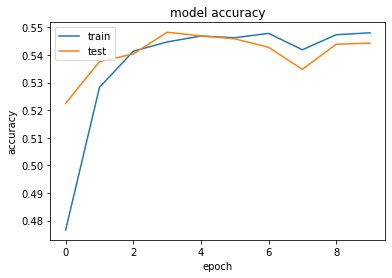

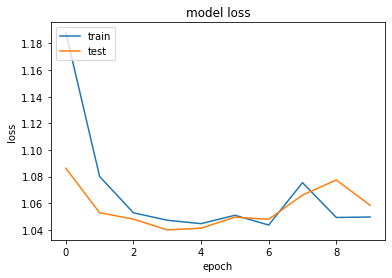

In [52]:
import matplotlib.pyplot as plt

plt.plot(history_c.history['acc'])
plt.plot(history_c.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history_c.history['loss'])
plt.plot(history_c.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

Parameters For Each Model:

1) CNN :
-->input_size/Input Layer = 100
-->activation = relu
-->Output/Dense Layer = 5 (Activation = Softmax)
-->Learning Rate = 0.001
-->Optimizer = Adam


2) LSTM :
-->input_size/Input Layer = 100
-->activation = relu
-->Dense Layer = 100
-->Dropout = 0.5
-->Output/Dense Layer = 5 (Activation = Softmax)
-->Learning Rate = 0.001
-->Optimizer = RMSProp


3) Bidirectional-LSTM :
-->input_size/Input Layer = 100
-->activation = relu
-->Dense Layer = 100
-->Dropout = 0.5
-->Output/Dense Layer = 5 (Activation = Softmax)
-->Learning Rate = 0.001
-->Optimizer = RMSProp